# 음식배달에 걸리는 시간 예측하기

Time 2 vec : https://towardsdatascience.com/time2vec-for-time-series-features-encoding-a03a4f3f937e

https://ojus1.github.io/posts/time2vec/

In [69]:
# 필요한 라이브러리 불러오기

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [70]:
# 데이터 불러오기 및 전처리
data = pd.read_csv('./delivery_raw.csv',sep='\t')

data.dropna(axis=0, how='all', subset=['actual_delivery_time'], inplace=True)       # 도착시간이 null인경우 해당 raw삭제
data['market_id'].fillna(value=7.0, inplace=True)
data['created_at'] = pd.to_datetime(data['created_at'])
data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'])
data['target'] = (data['actual_delivery_time'] - data['created_at']).dt.seconds
data.astype({
    'market_id' : int
})

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift,total_busy,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,target
0,1,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779
1,2,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024
2,3,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781
3,3,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075
4,3,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,1,2015-02-17 00:19:41,2015-02-17 01:24:48,2956,fast,4.0,3,1389,3,345,649,17.0,17.0,23.0,251,331.0,3907
197424,1,2015-02-13 00:01:59,2015-02-13 00:58:22,2956,fast,4.0,6,3010,4,405,825,12.0,11.0,14.0,251,915.0,3383
197425,1,2015-01-24 04:46:08,2015-01-24 05:36:16,2956,fast,4.0,5,1836,3,300,399,39.0,41.0,40.0,251,795.0,3008
197426,1,2015-02-01 18:18:15,2015-02-01 19:23:22,3630,sandwich,1.0,1,1175,1,535,535,7.0,7.0,12.0,446,384.0,3907


In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197421 entries, 0 to 197427
Data columns (total 17 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     197421 non-null  float64       
 1   created_at                                    197421 non-null  datetime64[ns]
 2   actual_delivery_time                          197421 non-null  datetime64[ns]
 3   store_id                                      197421 non-null  int64         
 4   store_primary_category                        192661 non-null  object        
 5   order_protocol                                196426 non-null  float64       
 6   total_items                                   197421 non-null  int64         
 7   subtotal                                      197421 non-null  int64         
 8   num_distinct_items                            197421 n

# EDA
## 범주형
1. 명목형 : market_id, store_id, store_primary_category, order_protocol
2. 순서형

## 수치형
1. 이산형 : total_items, subtotal, num_distinct_items, min_item_price, max_item_price, total_onshift, total_busy, total_outstanding_orders
2. 연속형 : created_at, estimated_store_to_consumer_driving_duration, estimated_order_place_duration

<Axes: xlabel='market_id', ylabel='Count'>

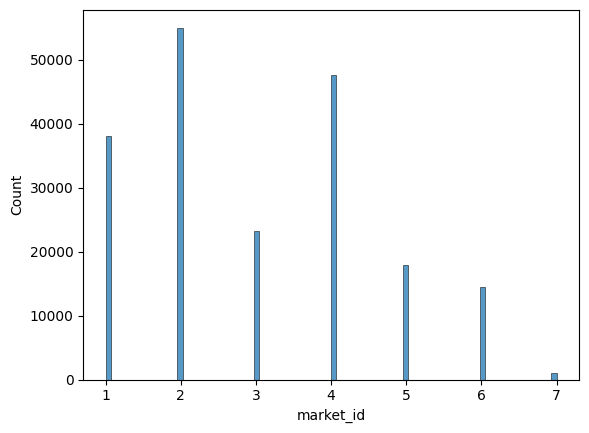

In [73]:
sns.histplot(data['market_id'])

In [54]:
data['market_id'].unique()

array([ 1.,  2.,  3.,  4., nan,  5.,  6.])

In [31]:
# 식당 속성 (식당id, 식당 카테고리, 주문방법)
data['store_id'].nunique(),data['store_primary_category'].nunique() , data['order_protocol'].nunique()

(6743, 74, 7)

In [32]:
# 주문 속성(음식 수, 가격, 음식 종류, )
data['total_items'].nunique(),data['subtotal'].nunique() , data['num_distinct_items'].nunique()

(57, 8368, 20)

In [48]:
data['store_primary_category']

0         american
1          mexican
2              NaN
3              NaN
4              NaN
            ...   
197423        fast
197424        fast
197425        fast
197426    sandwich
197427    sandwich
Name: store_primary_category, Length: 197421, dtype: object